<h1 align=center><font size = 5>Identifying the Ideal Places to Work</font></h1>
<h2 align=center><font size = 4>Segmenting and Clustering Universities in Manhattan</font></h2>
<br>

## Downloading the necessary libraries

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c districtdatalabs yellowbrick --yes
from yellowbrick.cluster import KElbowVisualizer

import matplotlib as mpl
import matplotlib.pyplot as plt

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge

The following packages will be UPDATED:

    certifi: 2019.11.28-py36_0 --> 2019.11.28-py36_0 conda-forge

The following packages will be DOWNGRADED:

    openssl: 1.1.1d-h7b6447c_4 --> 1.1.1d-h516909a_0 conda-forge


certifi-2019.11.28   | 149 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Solving environment: done


==> WARNING: A newer version of conda

<a id='item1'></a>

## Entering the institutions' neighborhood and coordinates

In [2]:
university_data = pd.DataFrame(
    {"Borough":["Manhattan", "Manhattan", "Manhattan", "Manhattan", "Manhattan",
                "Manhattan", "Manhattan", "Manhattan", "Manhattan", "Manhattan",
                "Manhattan", "Manhattan", "Manhattan", "Manhattan", "Manhattan",
                "Manhattan", "Manhattan", "Manhattan", "Manhattan", "Manhattan", "Manhattan"],
     "Institution":["Columbia University", "New York University", "Cooper Union", "Marymount Manhattan College", "New York Institute of Technology", 
                    "Juilliard School", "Pace University", "Berkeley College", "The New School", "Yeshiva University", 
                    "Parsons School of Design", "The City College of New York", "Hunter College", "CUNY Graduate Center", "Baruch College", 
                    "John Jay College of Criminal Justice", "Fashion Institute of Technology", "Pratt Institute", "Mercy College", "Cornell Tech", "Fordham University Lincoln Center"],
     "Neighborhood":["Morningside Heights", "Greenwich Village", " East Village", "Upper East Side", "Columbus Circle", 
                    "Lincoln Center", "Civic Center", "Midtown", "Greenwich Village", "Washington Heights", 
                    "Greenwich Village", "Hamilton Heights", "Upper East Side", "Midtown", "Gramercy", 
                    "Lincoln Center", "Chelsea", "Chelsea", "Herald Square", "Roosevelt Island", "Lincoln Center"],
     "Latitude":[40.8082115, 40.7302614, 40.7280661, 40.7687799, 40.7696949, 
                 40.773892, 40.7110619, 40.7539074, 40.7355119, 40.850545, 
                 40.7351321, 40.8200383, 40.7678324, 40.7485332, 40.7403786, 
                 40.7707272, 40.7471914, 40.7381827, 40.7497627, 40.7547402, 40.7710777], 
     "Longitude":[-73.9619672, -73.9982155, -73.9917347, -73.9599495, -73.9825805, 
                  -73.9831513, -74.0049277, -73.9795576, -73.9943513, -73.9296011, 
                  -73.9945457, -73.9490965, -73.9645156, -73.9837935, -73.9832489, 
                  -73.9893415, -73.9949671, -73.9989458, -73.9871082, -73.9566247, -73.9853614]})
university_data

,Borough,Institution,Neighborhood,Latitude,Longitude
0,Manhattan,Columbia University,Morningside Heights,40.808211,-73.961967
1,Manhattan,New York University,Greenwich Village,40.730261,-73.998216
2,Manhattan,Cooper Union,East Village,40.728066,-73.991735
3,Manhattan,Marymount Manhattan College,Upper East Side,40.768780,-73.959949
4,Manhattan,New York Institute of Technology,Columbus Circle,40.769695,-73.982580
5,Manhattan,Juilliard School,Lincoln Center,40.773892,-73.983151
6,Manhattan,Pace University,Civic Center,40.711062,-74.004928
7,Manhattan,Berkeley College,Midtown,40.753907,-73.979558
8,Manhattan,The New School,Greenwich Village,40.735512,-73.994351
9,Manhattan,Yeshiva University,Washington Heights,40.850545,-73.929601


### Creating a map of Manhattan with institutions superimposed on top

In [3]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


In [4]:
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, label in zip(university_data['Latitude'], university_data['Longitude'], university_data['Institution']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1.0,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

## Defining Foursquare credentials and version

In [5]:
CLIENT_ID = 'KAVCX5TMUL3UP5ME1AJ2B0NMCMQLWT2SWE2FRL4KXKB14OYZ'
CLIENT_SECRET = 'PZQXSC5XVSZVHGKTTUZ33XGSUAKL4GPAPD1L10UCZNZCTVBX'
VERSION = '20180605'

## Exploring the institutions in Manhattan

### Creating the function and dataframe

In [6]:
def getNearbyVenues(names, latitudes, longitudes, radius=500 ,limit=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Institution', 
                  'Institution Latitude', 
                  'Institution Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

manhattan_venues = getNearbyVenues(names=university_data['Institution'],
                                   latitudes=university_data['Latitude'],
                                   longitudes=university_data['Longitude']
                                  )

Columbia University
New York University
Cooper Union
Marymount Manhattan College
New York Institute of Technology
Juilliard School
Pace University
Berkeley College
The New School
Yeshiva University
Parsons School of Design
The City College of New York
Hunter College
CUNY Graduate Center
Baruch College
John Jay College of Criminal Justice
Fashion Institute of Technology
Pratt Institute
Mercy College
Cornell Tech
Fordham University Lincoln Center


### Exploring the resulting dataframe

In [7]:
print(manhattan_venues.shape)
manhattan_venues.head()

(1821, 7)


,Institution,Institution Latitude,Institution Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Columbia University,40.808211,-73.961967,Alma Mater Statue,40.807726,-73.962252,Outdoor Sculpture
1,Columbia University,40.808211,-73.961967,Arts and Crafts Beer Parlor,40.806689,-73.961094,Pub
2,Columbia University,40.808211,-73.961967,Nous Espresso Bar - Graduate Student Center,40.807533,-73.960879,Café
3,Columbia University,40.808211,-73.961967,Columbia Greenmarket,40.807195,-73.964335,Farmers Market
4,Columbia University,40.808211,-73.961967,Friedman's,40.808332,-73.959943,American Restaurant


### Checking how many venues were returned for each neighborhood

In [8]:
manhattan_venues.groupby('Institution').count()

,Institution Latitude,Institution Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Institution,,,,,,
Baruch College,100,100,100,100,100,100
Berkeley College,100,100,100,100,100,100
CUNY Graduate Center,100,100,100,100,100,100
Columbia University,48,48,48,48,48,48
Cooper Union,100,100,100,100,100,100
Cornell Tech,15,15,15,15,15,15
Fashion Institute of Technology,100,100,100,100,100,100
Fordham University Lincoln Center,100,100,100,100,100,100
Hunter College,100,100,100,100,100,100


Matplotlib version:  2.2.2


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


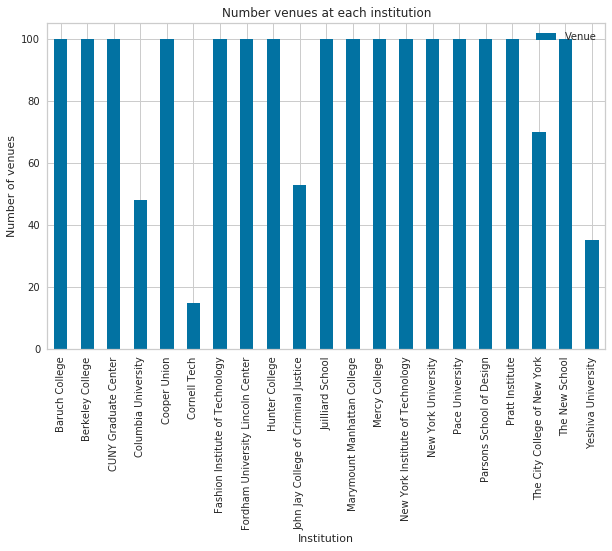

In [9]:
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

manhattan_plot = manhattan_venues[['Institution','Venue']].sort_values('Venue')

manhattan_venues_number = manhattan_plot.groupby('Institution').count()

manhattan_venues_number.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Institution')
plt.ylabel('Number of venues')
plt.title('Number venues at each institution')

plt.show()

In [10]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 249 uniques categories.


<a id='item3'></a>

## Analyzing each institution

In [11]:
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")
manhattan_onehot['Institution'] = manhattan_venues['Institution'] 
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]
manhattan_onehot.head()

,Institution,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comic Shop,Community Center,Concert Hall,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Columbia University,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [12]:
manhattan_onehot.shape

(1821, 250)

### Grouping rows by institution and by taking the mean of the frequency of occurrence of each category

In [13]:
manhattan_grouped = manhattan_onehot.groupby('Institution').mean().reset_index()
manhattan_grouped

,Institution,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Basketball Stadium,Bed & Breakfast,Beer Bar,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Bookstore,Boutique,Boxing Gym,Breakfast Spot,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Stop,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Caucasian Restaurant,Cheese Shop,Chinese Restaurant,Christmas Market,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Comic Shop,Community Center,Concert Hall,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,High School,Historic Site,History Museum,Hobby Shop,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Laundry Service,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Other Great Outdoors,Outdoor Sculpture,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Physical Therapist,Piano Bar,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soba Restaurant,Social Club,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tapas Restaurant,Tattoo Parlor,Tea Room,Tech Startup,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Train Station,Tram Station,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Watch Shop,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Baruch College,0.00,0.00,0.00,0.050000,0.00,0.01,0.020000,0.00,0.00,0.000000,0.000000,0.01,0.00,0.010000,0.010000,0.000000,0.040000,0.000000,0.000000,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.0100,0.01,0.00,0.00,0.00,0.00,0.000000,0.010000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00,0.00,0.030000,0.00,0.00,0.000000,0.000000,0.

In [14]:
manhattan_grouped.shape

(21, 250)

### Listing the top 5 most common venues at each institution

In [15]:
num_top_venues = 5

for hood in manhattan_grouped['Institution']:
    print("----"+hood+"----")
    temp = manhattan_grouped[manhattan_grouped['Institution'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Baruch College----
                 venue  freq
0    Indian Restaurant  0.08
1  American Restaurant  0.05
2           Restaurant  0.04
3                  Bar  0.04
4          Coffee Shop  0.04


----Berkeley College----
                 venue  freq
0          Coffee Shop  0.05
1  American Restaurant  0.04
2       Clothing Store  0.04
3  Sporting Goods Shop  0.04
4         Cocktail Bar  0.04


----CUNY Graduate Center----
                  venue  freq
0     Korean Restaurant  0.20
1  Gym / Fitness Center  0.04
2          Dessert Shop  0.04
3   Japanese Restaurant  0.03
4                Bakery  0.03


----Columbia University----
                 venue  freq
0                 Café  0.06
1  American Restaurant  0.06
2       Sandwich Place  0.06
3                 Park  0.06
4            Bookstore  0.06


----Cooper Union----
                 venue  freq
0   Italian Restaurant  0.07
1         Cocktail Bar  0.04
2                  Spa  0.04
3          Yoga Studio  0.03
4  Japanese Restaur

### Putting the top 10 results for each institution into a *pandas* dataframe

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Institution']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Institution'] = manhattan_grouped['Institution']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Institution,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Baruch College,Indian Restaurant,American Restaurant,Restaurant,Coffee Shop,Bar,Chinese Restaurant,Cocktail Bar,Gym / Fitness Center,Hotel,Ice Cream Shop
1,Berkeley College,Coffee Shop,American Restaurant,Sporting Goods Shop,Clothing Store,Cocktail Bar,Steakhouse,Gourmet Shop,Bakery,Gym / Fitness Center,Chinese Restaurant
2,CUNY Graduate Center,Korean Restaurant,Gym / Fitness Center,Dessert Shop,Bar,Steakhouse,Japanese Restaurant,Bakery,Scenic Lookout,Sandwich Place,Hotel
3,Columbia University,Bookstore,Park,American Restaurant,Café,Sandwich Place,Deli / Bodega,Coffee Shop,Food Truck,Pub,Chinese Restaurant
4,Cooper Union,Italian Restaurant,Spa,Cocktail Bar,Yoga Studio,Gym / Fitness Center,Bar,Grocery Store,Sushi Restaurant,Japanese Restaurant,American Restaurant
5,Cornell Tech,Park,Plaza,Tram Station,Café,Dog Run,Baseball Field,Tennis Court,Roof Deck,Athletics & Sports,Gym
6,Fashion Institute of Technology,Gym / Fitness Center,Coffee Shop,Pizza Place,Sandwich Place,Flower Shop,Gym,Hotel,Boxing Gym,Bakery,Salad Place
7,Fordham University Lincoln Center,Theater,Jazz Club,Plaza,Performing Arts Venue,Gym / Fitness Center,French Restaurant,Italian Restaurant,Park,Indie Movie Theater,Cosmetics Shop
8,Hunter College,French Restaurant,Italian Restaurant,Coffee Shop,Clothing Store,Café,Sporting Goods Shop,Women's Store,Art Museum,Boutique,Cycle Studio
9,John Jay College of Criminal Justice,Gym / Fitness Center,Park,Coffee Shop,Performing Arts Venue,Wine Bar,Opera House,Hotel,Cupcake Shop,Sushi Restaurant,Noodle House


<a id='item4'></a>

## Clustering institutions

### Using the Elbow Method to find the optimal value for k

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


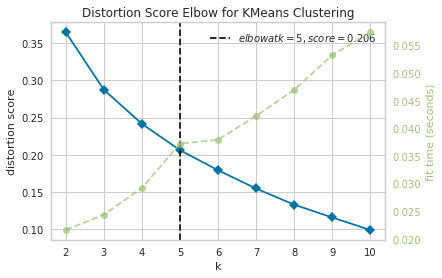

In [18]:
manhattan_grouped_clustering = manhattan_grouped.drop('Institution', 1)
model = KElbowVisualizer(KMeans(), k=10)
model.fit(manhattan_grouped_clustering)
model.show()

In [19]:
kclusters = 5
manhattan_grouped_clustering = manhattan_grouped.drop('Institution', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)
kmeans.labels_[0:10] 

array([1, 1, 0, 1, 1, 2, 1, 4, 1, 1], dtype=int32)

### Creating a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [20]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
manhattan_merged = university_data
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Institution'), on='Institution')
manhattan_merged.head()

,Borough,Institution,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Columbia University,Morningside Heights,40.808211,-73.961967,1,Bookstore,Park,American Restaurant,Café,Sandwich Place,Deli / Bodega,Coffee Shop,Food Truck,Pub,Chinese Restaurant
1,Manhattan,New York University,Greenwich Village,40.730261,-73.998216,1,Italian Restaurant,Sandwich Place,American Restaurant,Seafood Restaurant,Bar,Pizza Place,Massage Studio,Jazz Club,Café,Indian Restaurant
2,Manhattan,Cooper Union,East Village,40.728066,-73.991735,1,Italian Restaurant,Spa,Cocktail Bar,Yoga Studio,Gym / Fitness Center,Bar,Grocery Store,Sushi Restaurant,Japanese Restaurant,American Restaurant
3,Manhattan,Marymount Manhattan College,Upper East Side,40.768780,-73.959949,1,Italian Restaurant,Coffee Shop,Café,Cocktail Bar,Pizza Place,Wine Shop,Gym,Gym / Fitness Center,Burger Joint,Liquor Store
4,Manhattan,New York Institute of Technology,Columbus Circle,40.769695,-73.982580,4,Theater,Performing Arts Venue,French Restaurant,Bakery,Jazz Club,Clothing Store,Plaza,Cosmetics Shop,Concert Hall,Burger Joint


Finally, let's visualize the resulting clusters

In [21]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Institution'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1.).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## Examining Clusters to determine the discriminating venue categories that distinguish each cluste

### Cluster 1 - Koreatown

In [28]:
df1 = (manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1,2] + list(range(5, manhattan_merged.shape[1]))]])
df1

,Institution,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,CUNY Graduate Center,Midtown,0,Korean Restaurant,Gym / Fitness Center,Dessert Shop,Bar,Steakhouse,Japanese Restaurant,Bakery,Scenic Lookout,Sandwich Place,Hotel
18,Mercy College,Herald Square,0,Korean Restaurant,Hotel,Japanese Restaurant,Dessert Shop,American Restaurant,Coffee Shop,Gym / Fitness Center,Cosmetics Shop,Ramen Restaurant,Boutique


### Cluster 2 - Restaurants, Coffee Shops, and Bars Everywhere

In [29]:
df2 = (manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1,2] + list(range(5, manhattan_merged.shape[1]))]])
df2

,Institution,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Columbia University,Morningside Heights,1,Bookstore,Park,American Restaurant,Café,Sandwich Place,Deli / Bodega,Coffee Shop,Food Truck,Pub,Chinese Restaurant
1,New York University,Greenwich Village,1,Italian Restaurant,Sandwich Place,American Restaurant,Seafood Restaurant,Bar,Pizza Place,Massage Studio,Jazz Club,Café,Indian Restaurant
2,Cooper Union,East Village,1,Italian Restaurant,Spa,Cocktail Bar,Yoga Studio,Gym / Fitness Center,Bar,Grocery Store,Sushi Restaurant,Japanese Restaurant,American Restaurant
3,Marymount Manhattan College,Upper East Side,1,Italian Restaurant,Coffee Shop,Café,Cocktail Bar,Pizza Place,Wine Shop,Gym,Gym / Fitness Center,Burger Joint,Liquor Store
6,Pace University,Civic Center,1,Coffee Shop,Italian Restaurant,Hotel,Café,Sandwich Place,Park,French Restaurant,Falafel Restaurant,Taco Place,Indian Restaurant
7,Berkeley College,Midtown,1,Coffee Shop,American Restaurant,Sporting Goods Shop,Clothing Store,Cocktail Bar,Steakhouse,Gourmet Shop,Bakery,Gym / Fitness Center,Chinese Restaurant
8,The New School,Greenwich Village,1,Gym / Fitness Center,Yoga Studio,Vegetarian / Vegan Restaurant,Coffee Shop,Clothing Store,Grocery Store,Cosmetics Shop,Japanese Restaurant,American Restaurant,Italian Restaurant
10,Parsons School of Design,Greenwich Village,1,Gym / Fitness Center,Yoga Studio,Coffee Shop,American Restaurant,Japanese Restaurant,Italian Restaurant,Grocery Store,Cosmetics Shop,Clothing Store,Mediterranean Restaurant
11,The City College of New York,Hamilton Heights,1,Deli / Bodega,Mexican Restaurant,Sandwich Place,Café,Coffee Shop,Pizza Place,Park,Bakery,Cocktail Bar,Bar
12,Hunter College,Upper East Side,1,French Restaurant,Italian Restaurant,Coffee Shop,Clothing Store,Café,Sporting Goods Shop,Women's Store,Art Museum,Boutique,Cycle Studio


### Cluster 3 - Enjoying the Outdoors Due to Minimal Options

In [31]:
df3 = (manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1,2] + list(range(5, manhattan_merged.shape[1]))]])
df3

,Institution,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Cornell Tech,Roosevelt Island,2,Park,Plaza,Tram Station,Café,Dog Run,Baseball Field,Tennis Court,Roof Deck,Athletics & Sports,Gym


### Cluster 4 - Hispanic Community Offerings

In [32]:
df4 = (manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 3, manhattan_merged.columns[[1,2] + list(range(5, manhattan_merged.shape[1]))]])
df4

,Institution,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Yeshiva University,Washington Heights,3,Mobile Phone Shop,Supplement Shop,Café,Donut Shop,Mexican Restaurant,Seafood Restaurant,Latin American Restaurant,Spanish Restaurant,Lounge,Burger Joint


### Cluster 5 - Performing Arts Mecca

In [33]:
df5 = (manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 4, manhattan_merged.columns[[1,2] + list(range(5, manhattan_merged.shape[1]))]])
df5

,Institution,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,New York Institute of Technology,Columbus Circle,4,Theater,Performing Arts Venue,French Restaurant,Bakery,Jazz Club,Clothing Store,Plaza,Cosmetics Shop,Concert Hall,Burger Joint
5,Juilliard School,Lincoln Center,4,Theater,Italian Restaurant,Café,Concert Hall,Plaza,Performing Arts Venue,French Restaurant,Indie Movie Theater,Gym / Fitness Center,American Restaurant
20,Fordham University Lincoln Center,Lincoln Center,4,Theater,Jazz Club,Plaza,Performing Arts Venue,Gym / Fitness Center,French Restaurant,Italian Restaurant,Park,Indie Movie Theater,Cosmetics Shop


In [34]:
frames = [df1, df2, df3, df4, df5]
result = pd.concat(frames)
result

,Institution,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,CUNY Graduate Center,Midtown,0,Korean Restaurant,Gym / Fitness Center,Dessert Shop,Bar,Steakhouse,Japanese Restaurant,Bakery,Scenic Lookout,Sandwich Place,Hotel
18,Mercy College,Herald Square,0,Korean Restaurant,Hotel,Japanese Restaurant,Dessert Shop,American Restaurant,Coffee Shop,Gym / Fitness Center,Cosmetics Shop,Ramen Restaurant,Boutique
0,Columbia University,Morningside Heights,1,Bookstore,Park,American Restaurant,Café,Sandwich Place,Deli / Bodega,Coffee Shop,Food Truck,Pub,Chinese Restaurant
1,New York University,Greenwich Village,1,Italian Restaurant,Sandwich Place,American Restaurant,Seafood Restaurant,Bar,Pizza Place,Massage Studio,Jazz Club,Café,Indian Restaurant
2,Cooper Union,East Village,1,Italian Restaurant,Spa,Cocktail Bar,Yoga Studio,Gym / Fitness Center,Bar,Grocery Store,Sushi Restaurant,Japanese Restaurant,American Restaurant
3,Marymount Manhattan College,Upper East Side,1,Italian Restaurant,Coffee Shop,Café,Cocktail Bar,Pizza Place,Wine Shop,Gym,Gym / Fitness Center,Burger Joint,Liquor Store
6,Pace University,Civic Center,1,Coffee Shop,Italian Restaurant,Hotel,Café,Sandwich Place,Park,French Restaurant,Falafel Restaurant,Taco Place,Indian Restaurant
7,Berkeley College,Midtown,1,Coffee Shop,American Restaurant,Sporting Goods Shop,Clothing Store,Cocktail Bar,Steakhouse,Gourmet Shop,Bakery,Gym / Fitness Center,Chinese Restaurant
8,The New School,Greenwich Village,1,Gym / Fitness Center,Yoga Studio,Vegetarian / Vegan Restaurant,Coffee Shop,Clothing Store,Grocery Store,Cosmetics Shop,Japanese Restaurant,American Restaurant,Italian Restaurant
10,Parsons School of Design,Greenwich Village,1,Gym / Fitness Center,Yoga Studio,Coffee Shop,American Restaurant,Japanese Restaurant,Italian Restaurant,Grocery Store,Cosmetics Shop,Clothing Store,Mediterranean Restaurant
